In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from calc_full_NPCF_iso_direct import calc_NPCF
import sarabande
import os

plt.style.use("light_mode")

# Generate Data

In [2]:
nx = 128
data = np.zeros((nx,nx,nx))
np.random.seed(7)

xs, ys, zs, ws = [],[],[],[]
for x in range(nx):
    for y in range(nx):
        for z in range(nx):
            if np.random.randint(low=1, high=20000) == 300:
                data[x,y,z] = 1
                xs.append(x)
                ys.append(y)
                zs.append(z)
                ws.append(1)
                

print(f"There should be {len(np.where(data == 1)[0])} galaxies")
data_txt = np.array([xs, ys, zs, ws]).T   

There should be 104 galaxies


In [3]:
#save data
np.savetxt("direct_input_data/simple_data.txt", data_txt)

# 3PCF

## Direct Counting

In [20]:
start_time = time.time()

npcf = 3
nbins = 10
lbox = nx
rmax = nx/2
rmin=1e-14
verbose=False

zetas = calc_NPCF(npcf, data_txt, nbins, lbox, rmax, lls=None, verbose=verbose)
zetas.init_coeff()
zetas.run()
sdir = "direct_results/"
sname1 = sdir+f"simple_coeff_{npcf}pcf_nbins{nbins}_lbox{lbox}_rmax{rmax}"
zetas.save(sname1)
 
elapsed_time = time.time() - start_time
print(f"number of galaxies: {data_txt.shape[0]:1d}")
print(f"elapsed time: {elapsed_time:.3f} s")

no shift executed because in genuine box
>> save file to final_full_comparison_outputs/simple_coeff_3pcf_nbins10_lbox128_rmax64.0.pkl
number of galaxies: 104
elapsed time: 13.329 s


In [21]:
import pickle
zeta_direct = pickle.load(open(sdir+f"simple_coeff_{npcf}pcf_nbins{nbins}_lbox{lbox}_rmax{rmax}.pkl", "rb"))

n_r = nbins
r_arr = np.linspace(rmin,rmax,n_r+1)
r_lo = r_arr[:-1]
r_hi = r_arr[1:]
r_av = 0.5*(r_lo+r_hi)
V_bin = 4.*np.pi/3.*(r_hi**3.-r_lo**3.)

for ll in zeta_direct.keys():
    for bin1 in range(0, nbins, 1):
        for bin2 in range(bin1):
            norm = V_bin[bin1] * V_bin[bin2] 
            norm = 1 # No Normalization
            zeta_direct[ll][bin1, bin2] /= norm
            zeta_direct[ll][bin2, bin1] = zeta_direct[ll][bin1, bin2]

## Encore

In [53]:
def format_encore_output(npcf, folder, nbins, rmin, rmax, boxsize, Nmesh, ell_max=4):
    # Number of radial bins per dimension
    n_r = nbins

    def load_encore(N=4, R_file = None):
        if N>2:
            countsR = np.loadtxt(R_file,skiprows=5+N) # skipping rows with radial bins
        else:
            countsR = np.loadtxt(R_file,skiprows=5)
        # Extract ells and radial bins
        if N==2:
            bin1 = np.loadtxt(R_file,skiprows=4,max_rows=1)
            assert len(bin1)==n_r
            return bin1, countsR
        elif N==3:
            ell_1 = np.asarray(countsR[:,0],dtype=int)
            max_ell = np.max(ell_1)
            countsR = countsR[:,1:]
            bin1,bin2 = np.loadtxt(R_file,skiprows=6,max_rows=2)
            return ell_1,[bin1,bin2],countsR
        elif N==4:
            ell_1,ell_2,ell_3 = np.asarray(countsR[:,:3],dtype=int).T
            max_ell = np.max(ell_1)
            countsR = countsR[:,3:]
            bin1,bin2,bin3 = np.loadtxt(R_file,skiprows=6,max_rows=3)
            return [ell_1,ell_2,ell_3],[bin1,bin2,bin3],countsR
        else:
            raise Exception("%dPCF not yet configured"%N)


    # Load a bunch of simulations
    encore2pcfs, encore3pcfs, encore4pcfs = [],[],[]
    twopcf = load_encore(2,'encore_data/encore_final_comparison_2pcf.txt')
    threepcf = load_encore(3,'encore_data/encore_final_comparison_3pcf.txt')
    fourpcf = load_encore(4,'encore_data/encore_final_comparison_4pcf.txt')
    encore2pcfs.append(twopcf)
    encore3pcfs.append(threepcf)
    encore4pcfs.append(fourpcf)
        
    # Define radial bins
    r_arr = np.linspace(rmin,rmax,n_r+1)
    r_lo = r_arr[:-1]
    r_hi = r_arr[1:]
    r_av = 0.5*(r_lo+r_hi)
    V_bin = 4.*np.pi/3.*(r_hi**3.-r_lo**3.)
    
    if npcf == 2:
        ## Normalize 2PCF
        xi_encore = np.asarray([np.asarray(twopcf[1]/V_bin)*boxsize**3/Nmesh**6. for twopcf in encore2pcfs])
        return xi_encore, r_av
    
    elif npcf == 3:
        # print(threepcf[2].shape)
        zeta_list = []
        for n in range(len(encore3pcfs)):
            threepcf = encore3pcfs[n]
            zeta = np.zeros((ell_max + 1, nbins, nbins))
            for i in range(threepcf[2].shape[0]):
                l = threepcf[0][i]
                for j in range(threepcf[2].shape[1]):
                    b1,b2 = int(threepcf[1][0][j]), int(threepcf[1][1][j])
                    this_3pcf = threepcf[2][i,j]
                    norm = V_bin[b1] * V_bin[b2]
                    norm = 1 # No Normalization
                    this_3pcf /= norm
                    zeta[l,b1,b2] = this_3pcf 
                    zeta[l,b2,b1] = this_3pcf
                    
            zeta_list.append(zeta)
        return zeta_list[0], r_av

    # Normalize 4PCF and put into an easy to
    elif npcf == 4:
        zeta_list = []
        for n in range(len(encore4pcfs)):
            fourpcf = encore4pcfs[n]
            zeta = np.zeros((ell_max+1, ell_max+1, ell_max+1,nbins, nbins, nbins))
            for i in range(fourpcf[2].shape[0]): # iterate over first axis
                l1, l2, l3 = fourpcf[0][0][i],fourpcf[0][1][i], fourpcf[0][2][i] 
                # find out which {l1,l2,l3} this row corresponds to
                for j in range(fourpcf[2].shape[1]): # iterate over second axis
                    b1, b2, b3 = int(fourpcf[1][0][j]), int(fourpcf[1][1][j]), int(fourpcf[1][2][j]) 
                    # find out which {b1, b2, b3} this column corresponds to 
                    this_4pcf = fourpcf[2][i,j]
                    norm = V_bin[b1]*V_bin[b2]*V_bin[b3]
                    norm = 1 # No Normalization
                    this_4pcf /= norm
                    # this_4pcf *= (4*np.pi)**(3) * (boxsize**9/Nmesh**12) 
                    zeta[l1,l2,l3,b1,b2,b3] = this_4pcf
                    zeta[l3,l1,l2,b3,b1,b2] = this_4pcf
                    zeta[l2,l3,l1,b2,b3,b1] = this_4pcf
                    zeta[l1,l3,l2,b1,b3,b2] = this_4pcf
                    zeta[l2,l1,l3,b2,b1,b3] = this_4pcf
                    zeta[l3,l2,l1,b3,b2,b1] = this_4pcf
            zeta_list.append(zeta)

        return zeta_list[0], r_av
    else:
        print("This is not yet implemented")




In [23]:
zeta_encore, r_av = format_encore_output(npcf=npcf, folder="",
                                         nbins=nbins, rmin=rmin,
                                         rmax=nx/2, boxsize=lbox,
                                         Nmesh=nx, ell_max=4)



## Sarabande

In [25]:
#string to directory to save data into
save_dir = os.getcwd() + '/output/'

#create measure_obj
_3PCF = sarabande.measure(nPCF=npcf, projected=False, ell_max=2, density_field_data = data,
                                   save_dir=save_dir, save_name='example', nbins=nbins,
                                   physical_boxsize=lbox, rmin=rmin, rmax=rmax, normalize=False,
                                   particles_on_grid=True)

sarabande.calc_zeta(_3PCF, verbose_flag=False)

Preparing the data:
Creating XYZ Grids for radial bin and ylm creation ... 

Creating radial bins ... 

taking the fourier transform of data ... 

calculating YLM Coefficients ... 

binning spherical harmonics ... 

ell, m =  0 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
ell, m =  1 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
ell, m =  1 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
ell, m =  2 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
ell, m =  2 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
ell, m =  2 2
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
calculating a_lm coefficients ... 

l, m

## Format Coefficients to 1D

In [26]:
nbins = len(r_av)
l = 2

In [27]:
#ENCORE
zeta_1d,bin_indexes,b_i = [], [], 0

for b1 in range(0,nbins):
    for b2 in range(b1):
        value = zeta_encore[l,b1,b2].real 
        # value *= (r_av[b1] * r_av[b2])
        zeta_1d.append(value)
        bin_indexes.append(b_i)
        b_i += 1
        
zeta_1d_encore, bin_indexes_encore = zeta_1d, bin_indexes


In [28]:
#SARABANDE
zeta_l_1d, bin_indexes, b_i = [], [], 0
for b1 in range(0,nbins):
    for b2 in range(b1):
        value = _3PCF.zeta[l,b1,b2].real
        # value *= r_av[b1] * r_av[b2]
        zeta_l_1d.append(value)
        bin_indexes.append(b_i)
        b_i += 1
        
zeta_1d_sar, bin_indexes_sar = np.array(zeta_l_1d), np.array(bin_indexes)

In [29]:
#DIRECT COUNTING
ell = 2 * str(l)
zeta_l_1d, bin_indexes, b_i = [], [], 0
for b1 in range(0,nbins):
    for b2 in range(b1):
        value = zeta_direct[ell][b1,b2].real
        # value *= r_av[b1] * r_av[b2]
        zeta_l_1d.append(value)
        bin_indexes.append(b_i)
        b_i += 1
        
zeta_1d_DC, bin_indexes_DC = np.array(zeta_l_1d), np.array(bin_indexes)

In [33]:
bin_indexes_sar_3PCF, zeta_1d_sar_3PCF = bin_indexes_sar, zeta_1d_sar
bin_indexes_encore_3PCF, zeta_1d_encore_3PCF = bin_indexes_encore, zeta_1d_encore
bin_indexes_DC_3PCF, zeta_1d_DC_3PCF = bin_indexes_DC, zeta_1d_DC

# 4PCF

## Direct Counting

In [35]:
start_time = time.time()

npcf = 4
nbins = 10
lbox = nx
rmax = nx/2
rmin=1e-14
verbose=False

zetas = calc_NPCF(npcf, data_txt, nbins, lbox, rmax, lls=None, verbose=verbose)
zetas.init_coeff()
zetas.run()
sdir = "direct_results/"
sname1 = sdir+f"simple_coeff_{npcf}pcf_nbins{nbins}_lbox{lbox}_rmax{rmax}"
zetas.save(sname1)
 
elapsed_time = time.time() - start_time
print(f"number of galaxies: {data_txt.shape[0]:1d}")
print(f"elapsed time: {elapsed_time:.3f} s")

no shift executed because in genuine box
>> save file to final_full_comparison_outputs/simple_coeff_4pcf_nbins10_lbox128_rmax64.0.pkl
number of galaxies: 104
elapsed time: 677.376 s


In [36]:
zeta_direct = pickle.load(open(sdir+f"simple_coeff_{npcf}pcf_nbins{nbins}_lbox{lbox}_rmax{rmax}.pkl", "rb"))
zeta_direct.pop("111") # we ignore odd parity for now


n_r = nbins
r_arr = np.linspace(rmin,rmax,n_r+1)
r_lo = r_arr[:-1]
r_hi = r_arr[1:]
r_av = 0.5*(r_lo+r_hi)
V_bin = 4.*np.pi/3.*(r_hi**3.-r_lo**3.)


ell_max = 2
keys = ['110', '112', '222']
for ll in keys:
    print(ll)
    l1_, l2_, l3_ = ll   
    l1, l2, l3 = int(l1_), int(l2_), int(l3_)
    
    if l3 >= np.abs(l1 - l2) and l3 <= min(l1 + l2, ell_max)+1:
        
        if (l1 + l2 + l3)%2 != 0: # we don't assume this to be true for Turbulent ISM
            continue
            
        try:
            zeta_direct[l3_+l1_+l2_]
        except:
            zeta_direct[l3_+l1_+l2_] = np.zeros((nbins, nbins, nbins)) + 0j
            
        try: 
            zeta_direct[l2_+l3_+l1_]
        except:
            zeta_direct[l2_+l3_+l1_] = np.zeros((nbins, nbins, nbins)) + 0j
    
        try:
            zeta_direct[l1_+l3_+l2_]
        except:
            zeta_direct[l1_+l3_+l2_] = np.zeros((nbins, nbins, nbins)) + 0j
        
        try:
            zeta_direct[l2_+l1_+l3_]
        except:
            zeta_direct[l2_+l1_+l3_] = np.zeros((nbins, nbins, nbins)) + 0j
            
        try:
            zeta_direct[l3_+l2_+l1_]
        except:
            zeta_direct[l3_+l2_+l1_] = np.zeros((nbins, nbins, nbins)) + 0j
            
            
        for b1 in range(0, nbins, 1):
            for b2 in range(b1+1): #?? for bin2 in range(0, bin2<=bin1, 1):
                for b3 in range(b2+1):
                    # print(l1,l2,l3, b1,b2,b3)
                    
                    norm= V_bin[b1]*V_bin[b2]*V_bin[b3]
                    norm = 1
                    zeta_direct[ll][b1,b2,b3] /= norm
                    this_4pcf = zeta_direct[ll][b1,b2,b3]
                    zeta_direct[l3_+l1_+l2_][b3,b1,b2] = this_4pcf
                    zeta_direct[l2_+l3_+l1_][b2,b3,b1] = this_4pcf
                    zeta_direct[l1_+l3_+l2_][b1,b3,b2] = this_4pcf
                    zeta_direct[l2_+l1_+l3_][b2,b1,b3] = this_4pcf
                    zeta_direct[l3_+l2_+l1_][b3,b2,b1] = this_4pcf
                    

110
112
222


## Encore

In [182]:
zeta_encore, r_av = format_encore_output(npcf=4, folder="",
                                         nbins=nbins, rmin=0.0001,
                                         rmax=nx/2, boxsize=lbox,
                                         Nmesh=nx, ell_max=4)

4


## Sarabande

In [40]:
#string to directory to save data into
save_dir = os.getcwd() + '/output/'

#create measure_obj
_4PCF = sarabande.measure(nPCF=4, projected=False, ell_max=2, density_field_data = data,
                                   save_dir=save_dir, save_name='example', nbins=nbins,
                                   physical_boxsize=lbox, rmin=rmin, rmax=rmax, normalize=False,
                                   particles_on_grid=True)

sarabande.calc_zeta(_4PCF, verbose_flag=False)

Preparing the data:
Creating XYZ Grids for radial bin and ylm creation ... 

Creating radial bins ... 

taking the fourier transform of data ... 

calculating YLM Coefficients ... 

binning spherical harmonics ... 

ell, m =  0 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
ell, m =  1 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
ell, m =  1 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
ell, m =  2 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
ell, m =  2 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
ell, m =  2 2
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
calculating a_lm coefficients ... 

l, m

## Format Coefficients to 1D

In [191]:
ells = "112"

In [192]:
#ENCORE
zeta_l_1d,bin_indexes,b_i = [], [], 0
l_1,l_2,l_3 = int(ells[0]),int(ells[1]),int(ells[2])
for b1 in range(0,nbins):
    for b2 in range(b1):
        for b3 in range(b2):
            value = zeta_encore[l_1,l_2,l_3,b1,b2,b3].real 
            # value *= (r_av[b1] * r_av[b2] * r_av[b3])
            zeta_l_1d.append(value)
            bin_indexes.append(b_i)
            b_i += 1

zeta_1d_encore, bin_indexes_encore = np.array(zeta_l_1d), np.array(bin_indexes)

In [193]:
#SARABANDE
zeta_l_1d,bin_indexes,b_i = [], [], 0
l_1,l_2,l_3 = int(ells[0]),int(ells[1]),int(ells[2])
for b1 in range(0,nbins):
    for b2 in range(b1):
        for b3 in range(b2):
            value = _4PCF.zeta[l_1,l_2,l_3,b1,b2,b3].real 
            # value *= (r_av[b1] * r_av[b2] * r_av[b3])
            zeta_l_1d.append(value)
            bin_indexes.append(b_i)
            b_i += 1

zeta_1d_sar, bin_indexes_sar = np.array(zeta_l_1d), np.array(bin_indexes)

In [194]:
#DIRECT COUNTING
zeta_l_1d, bin_indexes, b_i = [], [], 0
for b1 in range(0,nbins):
    for b2 in range(b1):
        for b3 in range(b2):
            value = zeta_direct[ells][b1,b2,b3].real
            # value *= r_av[b1] * r_av[b2] * r_av[b3]
            zeta_l_1d.append(value)
            bin_indexes.append(b_i)
            b_i += 1
            
zeta_1d_DC, bin_indexes_DC = np.array(zeta_l_1d), np.array(bin_indexes)

In [196]:
bin_indexes_sar_4PCF, zeta_1d_sar_4PCF = bin_indexes_sar, zeta_1d_sar
bin_indexes_encore_4PCF, zeta_1d_encore_4PCF = bin_indexes_encore, zeta_1d_encore
bin_indexes_DC_4PCF, zeta_1d_DC_4PCF = bin_indexes_DC, zeta_1d_DC

# Plot Results

In [213]:
def create_NPCF_plot(ax_center, 
                     NPCF, 
                     sarabande_data, DC_data, encore_data,
                     offset_center, residual_factor,
                     c_bounds_l,c_bounds_r,
                     legend,
                     size="20%", pad=0):
    
    """
    ax_center: ax object
    NPCF: Int 3 or 4 for 3/4 PCF
    sarabande_data, DC_data: lists with [x_data, y_data]
    offset_center: how much we offset Re & Im parts
    residual_factor: factor we multiply residuals by to scale them by (14 -> R x 1e14)
    c_bounds_l,c_bounds_r: lower and upper bounds for center axis
    legend: bool to indicate if a legend is desired
    size: percentage string indicating the size of the residual axis
    pad: spacing between the center and residual axes
    
    """
    
    #divide the axes into two
    divider = make_axes_locatable(ax_center)
    ax_bottom = divider.append_axes("bottom", size=size, pad=pad)
    ax_center.figure.add_axes(ax_bottom)
    
    #format data
    sarabande_bins, zeta_1d_sarabande = sarabande_data
    direct_bins, zeta_1d_direct = DC_data
    encore_bins, zeta_1d_encore = encore_data
    
    #center plot
    
    # -----> labels & titles
    
        
    if NPCF == 3:
        ax_center.set_ylabel("$\\hat{\zeta}^{\mathrm{ \; b_1 b_2}}_{\\ell}$", 
                            fontsize=30)
    elif NPCF == 4:
        ax_center.set_ylabel("$\\hat{\zeta}^{\mathrm{ \; b_1 b_2 b_3}}_{\\ell_1 \\ell_2 \\ell_3}$",
                            fontsize=30)

    # -----> plotting data
    ax_center.plot(sarabande_bins, zeta_1d_sarabande + offset_center,
                   color="red", linestyle="-", linewidth=4,label="Sarabande")
    
    ax_center.plot(encore_bins, zeta_1d_encore + offset_center,
                   color="black", linestyle="dashdot", linewidth=4, label="Encore")
    
    ax_center.plot(direct_bins, zeta_1d_direct + offset_center,
                   color="dodgerblue", linestyle=":", linewidth=4, label="Direct Counting")

    # -----> bounds
    ax_center.set_xlim(0,len(direct_bins)-1)
    ax_center.set_ylim(c_bounds_l,c_bounds_r)
    
    # -----> grid & legend
    ax_center.set_xticklabels([])
    ax_center.grid()
    
    if legend:
        ax_center.legend(shadow=True, edgecolor="black", ncol=2, fontsize=18)
    
    #residual plot
    
    factor = 10**residual_factor
    
    # ax_bottom.plot(direct_bins, 
    #               (zeta_1d_direct - zeta_1d_sarabande) * factor,
    #                color="red",linestyle="--", linewidth=4)
    
    
    ax_bottom.plot(direct_bins, 
                  (zeta_1d_encore - zeta_1d_direct) * factor,
                   color="blue",linestyle="-", linewidth=4)
    
    ax_bottom.plot(direct_bins, 
                  (zeta_1d_encore - zeta_1d_sarabande) * factor,
                   color="red",linestyle="--", linewidth=4)
    
    
    
    
    ax_bottom.set_ylim(-9,9)
    ax_bottom.set_xlim(0,len(direct_bins)-1)
    label_str = "Residuals \n $\\times 10^{-" + str(residual_factor) + "}$"
    ax_bottom.set_ylabel(label_str)
    ax_bottom.set_xlabel("Bin Index")
    ax_bottom.grid()
    
    # ------------------------------

In [214]:
sarabande_3PCF_data = [bin_indexes_sar_3PCF, zeta_1d_sar_3PCF]
encore_3PCF_data = [bin_indexes_encore_3PCF, zeta_1d_encore_3PCF]
DC_3PCF_data = [bin_indexes_DC_3PCF, zeta_1d_DC_3PCF]

sarabande_4PCF_data = [bin_indexes_sar_4PCF, zeta_1d_sar_4PCF]
encore_4PCF_data = [bin_indexes_encore_4PCF, zeta_1d_encore_4PCF]
DC_4PCF_data = [bin_indexes_DC_4PCF, zeta_1d_DC_4PCF]

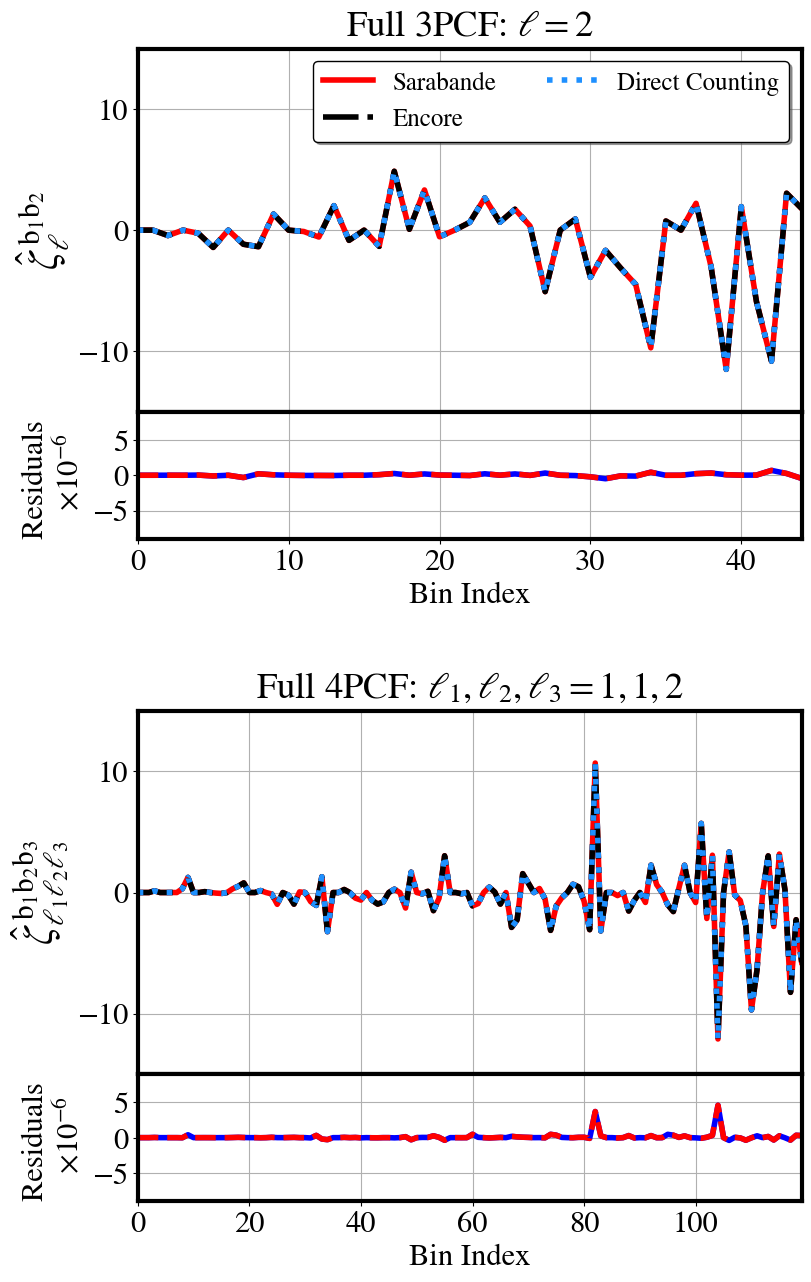

In [217]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,12), constrained_layout=True,
                         gridspec_kw={"height_ratios":[1,1], "hspace":0.22, "wspace":0.05})
                                                                            

create_NPCF_plot(axes[0], 3,
                 sarabande_3PCF_data, DC_3PCF_data, encore_3PCF_data,
                 offset_center = 0, residual_factor = 6,
                 c_bounds_l = -15,c_bounds_r = 15,
                 legend = True,
                 size="35%")
axes[0].set_title(f"Full 3PCF: $\\ell = {l}$", pad =10)


create_NPCF_plot(axes[1], 4,
                 sarabande_4PCF_data, DC_4PCF_data, encore_4PCF_data,
                 offset_center = 0, residual_factor = 6,
                 c_bounds_l = -15,c_bounds_r = 15,
                 legend = False,
                 size="35%")
axes[1].set_title(f"Full 4PCF: $\ell_1 , \ell_2 , \ell_3 = {ells[0]}, {ells[1]}, {ells[2]}$", pad =10)





# plt.tight_layout()  
# plt.savefig("Full_PCF_comparison_figure.pdf", dpi = 300, bbox_inches="tight")
plt.show()



## Generate Data

In [460]:
nx = 64
data = np.zeros((nx,nx,nx))
np.random.seed(7)

xs, ys, zs, ws = [],[],[],[]
for x in range(nx):
    for y in range(nx):
        for z in range(nx):
            if np.random.randint(low=1, high=20000) == 300:
                data[x,y,z] = 1
                xs.append(x)
                ys.append(y)
                zs.append(z)
                ws.append(1)
                

print(f"There should be {len(np.where(data == 1)[0])} galaxies")
data_txt = np.array([xs, ys, zs, ws]).T   

There should be 18 galaxies


In [461]:
#save data
np.savetxt("simple_data.txt", data_txt)

## 3PCF

### Encore

In [462]:
def format_encore_output(npcf, folder, nbins, rmin, rmax, boxsize, Nmesh, ell_max=4):
    # Number of radial bins per dimension
    n_r = nbins

    def load_encore(N=4, R_file = None):
        if N>2:
            countsR = np.loadtxt(R_file,skiprows=5+N) # skipping rows with radial bins
        else:
            countsR = np.loadtxt(R_file,skiprows=5)
        # Extract ells and radial bins
        if N==2:
            bin1 = np.loadtxt(R_file,skiprows=4,max_rows=1)
            assert len(bin1)==n_r
            return bin1, countsR
        elif N==3:
            ell_1 = np.asarray(countsR[:,0],dtype=int)
            max_ell = np.max(ell_1)
            countsR = countsR[:,1:]
            bin1,bin2 = np.loadtxt(R_file,skiprows=6,max_rows=2)
            return ell_1,[bin1,bin2],countsR
        elif N==4:
            ell_1,ell_2,ell_3 = np.asarray(countsR[:,:3],dtype=int).T
            max_ell = np.max(ell_1)
            countsR = countsR[:,3:]
            bin1,bin2,bin3 = np.loadtxt(R_file,skiprows=6,max_rows=3)
            return [ell_1,ell_2,ell_3],[bin1,bin2,bin3],countsR
        else:
            raise Exception("%dPCF not yet configured"%N)


    # Load a bunch of simulations
    encore2pcfs, encore3pcfs, encore4pcfs = [],[],[]
    twopcf = load_encore(2,'Final_Comparison_Testing/encore_final_comparison_2pcf.txt')
    threepcf = load_encore(3,'Final_Comparison_Testing/encore_final_comparison_3pcf.txt')
    fourpcf = load_encore(4,'Final_Comparison_Testing/encore_final_comparison_4pcf.txt')
    encore2pcfs.append(twopcf)
    encore3pcfs.append(threepcf)
    encore4pcfs.append(fourpcf)
        
    # Define radial bins
    r_arr = np.linspace(rmin,rmax,n_r+1)
    r_lo = r_arr[:-1]
    r_hi = r_arr[1:]
    r_av = 0.5*(r_lo+r_hi)
    V_bin = 4.*np.pi/3.*(r_hi**3.-r_lo**3.)
    
    if npcf == 2:
        ## Normalize 2PCF
        xi_encore = np.asarray([np.asarray(twopcf[1]/V_bin)*boxsize**3/Nmesh**6. for twopcf in encore2pcfs])
        return xi_encore, r_av
    
    elif npcf == 3:
        # print(threepcf[2].shape)
        zeta_list = []
        for n in range(len(encore3pcfs)):
            threepcf = encore3pcfs[n]
            zeta = np.zeros((ell_max + 1, nbins, nbins))
            for i in range(threepcf[2].shape[0]):
                l = threepcf[0][i]
                for j in range(threepcf[2].shape[1]):
                    b1,b2 = int(threepcf[1][0][j]), int(threepcf[1][1][j])
                    this_3pcf = threepcf[2][i,j]
                    norm = V_bin[b1] * V_bin[b2] 
                    this_3pcf /= norm
                    zeta[l,b1,b2] = this_3pcf 
                    zeta[l,b2,b1] = this_3pcf
                    
            zeta_list.append(zeta)
        return zeta_list[0], r_av

    # Normalize 4PCF and put into an easy to
    elif npcf == 4:
        zeta_list = []
        for n in range(len(encore4pcfs)):
            fourpcf = encore4pcfs[n]
            zeta = np.zeros((ell_max+1, ell_max+1, ell_max+1,nbins, nbins, nbins))
            for i in range(fourpcf[2].shape[0]): # iterate over first axis
                l1, l2, l3 = fourpcf[0][0][i],fourpcf[0][1][i], fourpcf[0][2][i] 
                # find out which {l1,l2,l3} this row corresponds to
                for j in range(fourpcf[2].shape[1]): # iterate over second axis
                    b1, b2, b3 = int(fourpcf[1][0][j]), int(fourpcf[1][1][j]), int(fourpcf[1][2][j]) 
                    # find out which {b1, b2, b3} this column corresponds to 
                    this_4pcf = fourpcf[2][i,j]
                    normalization = V_bin[b1]*V_bin[b2]*V_bin[b3]
                    this_4pcf /= normalization
                    # this_4pcf *= (4*np.pi)**(3) * (boxsize**9/Nmesh**12) 
                    zeta[l1,l2,l3,b1,b2,b3] = this_4pcf
                    zeta[l3,l1,l2,b3,b1,b2] = this_4pcf
                    zeta[l2,l3,l1,b2,b3,b1] = this_4pcf
                    zeta[l1,l3,l2,b1,b3,b2] = this_4pcf
                    zeta[l2,l1,l3,b2,b1,b3] = this_4pcf
                    zeta[l3,l2,l1,b3,b2,b1] = this_4pcf
            zeta_list.append(zeta)

        return zeta_list[0], r_av
    else:
        print("This is not yet implemented")




In [463]:
zeta_encore, r_av = format_encore_output(npcf=3, folder="", nbins=10, rmin=0.0001, rmax=64, boxsize=128, Nmesh=128, ell_max=4)

### Direct Counting

In [464]:
from calc_full_NPCF_iso_direct import calc_NPCF
import time

In [465]:
start_time = time.time()

npcf = 3
nbins = 10
lbox = 64
rmax = 32
rmin=1e-4
verbose=False

zetas = calc_NPCF(npcf, data_txt, nbins, lbox, rmax, lls=None, verbose=verbose)
zetas.init_coeff()
zetas.run()
sdir = ""
sname1 = sdir+f"simple_coeff_{npcf:0d}pcf_nbins{nbins:0d}_lbox{lbox:0d}_rmax{rmax:0d}"
zetas.save(sname1)
 
elapsed_time = time.time() - start_time
print(f"number of galaxies: {data_txt.shape[0]:1d}")
print(f"elapsed time: {elapsed_time:.3f} s")

no shift executed because in genuine box
>> save file to simple_coeff_3pcf_nbins10_lbox64_rmax32.pkl
number of galaxies: 18
elapsed time: 0.272 s


In [466]:
import pickle
zeta_direct = pickle.load(open("simple_coeff_3pcf_nbins10_lbox64_rmax32.pkl", "rb"))

n_r = nbins
r_arr = np.linspace(rmin,rmax,n_r+1)
r_lo = r_arr[:-1]
r_hi = r_arr[1:]
r_av = 0.5*(r_lo+r_hi)
V_bin = 4.*np.pi/3.*(r_hi**3.-r_lo**3.)

for ll in zeta_direct.keys():
    # zeta_direct[ll] *= 1./(4 * np.pi)
    for bin1 in range(0, nbins, 1):
        for bin2 in range(bin1): #?? for bin2 in range(0, bin2<=bin1, 1):
            norm = V_bin[bin1] * V_bin[bin2] 
            zeta_direct[ll][bin1, bin2] /= norm
            zeta_direct[ll][bin2, bin1] = zeta_direct[ll][bin1, bin2]

### Sarabande

In [467]:
import sarabande
import os

In [468]:
#string to directory to save data into
save_dir = os.getcwd() + '/output/'

#create measure_obj
_3PCF = sarabande.measure(nPCF=3, projected=False, ell_max=2, density_field_data = data,
                                   save_dir=save_dir, save_name='example', nbins=10,
                                   physical_boxsize=64, rmin=1e-4, rmax=32)

sarabande.calc_zeta(_3PCF, normalize=True)

Preparing the data:
Creating XYZ Grids for radial bin and ylm creation ... 

Creating radial bins ... 

taking the fourier transform of data ... 

calculating YLM Coefficients ... 

binning spherical harmonics ... 

ell, m =  0 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
ell, m =  1 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
ell, m =  1 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
ell, m =  2 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
ell, m =  2 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
ell, m =  2 2
bin i =  0
bin i =  1
bin i =  2
bin i =  3
bin i =  4
bin i =  5
bin i =  6
bin i =  7
bin i =  8
bin i =  9
calculating a_lm coefficients ... 

l, m

In [469]:
nbins = len(r_av)
l = 2

In [470]:
#ENCORE
zeta_1d,bin_indexes,b_i = [], [], 0

for b1 in range(0,nbins):
    for b2 in range(b1):
        value = zeta_encore[l,b1,b2].real 
        value *= (r_av[b1] * r_av[b2])
        zeta_1d.append(value)
        bin_indexes.append(b_i)
        b_i += 1
        
zeta_1d_encore, bin_indexes_encore = zeta_1d, bin_indexes


In [471]:
#SARABANDE
zeta_l_1d, bin_indexes, b_i = [], [], 0
for b1 in range(0,nbins):
    for b2 in range(b1):
        value = _3PCF.zeta[l,b1,b2].real
        value *= r_av[b1] * r_av[b2]
        zeta_l_1d.append(value)
        bin_indexes.append(b_i)
        b_i += 1
        
zeta_1d_sar, bin_indexes_sar = np.array(zeta_l_1d), np.array(bin_indexes)

In [472]:
#DIRECT COUNTING
ell = 2 * str(l)
zeta_l_1d, bin_indexes, b_i = [], [], 0
for b1 in range(0,nbins):
    for b2 in range(b1):
        value = zeta_direct[ell][b1,b2].real
        value *= r_av[b1] * r_av[b2]
        zeta_l_1d.append(value)
        bin_indexes.append(b_i)
        b_i += 1
        
zeta_1d_DC, bin_indexes_DC = np.array(zeta_l_1d), np.array(bin_indexes)

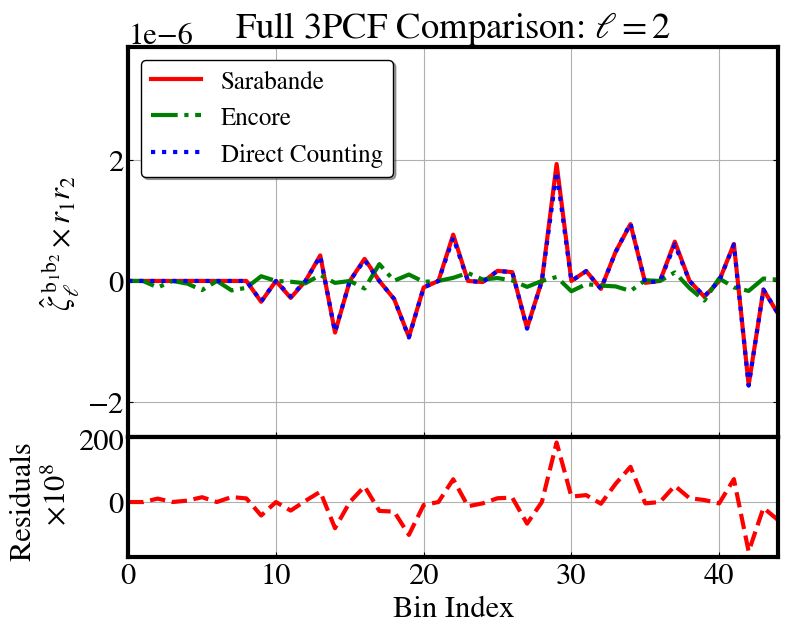

In [473]:
# definitions for the axes 
left, width = 0.1, 0.65 
bottom, height = 0.1, 0.65 
spacing = 0.0

rect_center = [left, bottom, width, height]
rect_bottomx = [left, -bottom + spacing, width, 0.2] 

# start with a rectangular Figure
fig = plt.figure(figsize=(10, 6)) 
ax_center = plt.axes(rect_center) 
ax_center.tick_params(direction='in', right=True) 
ax_bottomx = plt.axes(rect_bottomx)
ax_bottomx.tick_params(direction='in') 


# the center plot:
ax_center.set_xticklabels([])
ax_center.set_ylim(1.5 * np.min(zeta_1d_sar), 2 * np.max(zeta_1d_sar))
ax_center.set_title(f"Full 3PCF Comparison: $\\ell = {l}$")
ax_center.set_ylabel("$\\hat{\zeta}^{\mathrm{ \; b_1 b_2}}_{\ell} \\times r_1 r_2$")
ax_center.plot(bin_indexes_sar, zeta_1d_sar, color="red", linestyle="-", linewidth=3,label="Sarabande")
ax_center.plot(bin_indexes_encore, zeta_1d_encore, color="green", linestyle="-.", linewidth=3,label="Encore")
ax_center.plot(bin_indexes_DC, zeta_1d_DC, color="blue", linestyle=":", linewidth=3, label="Direct Counting")
ax_center.set_xlim(0,len(bin_indexes)-1)
ax_center.grid()
ax_center.legend(shadow=True, edgecolor="black", fontsize=18)


#redidual plot
ax_bottomx.plot(bin_indexes_encore, (zeta_1d_sar - zeta_1d_encore) * 1e8, color="red",linestyle="--", linewidth=3)
# ax_bottomx.set_ylim(-1.5,1.5)
ax_bottomx.set_xlim(0,len(bin_indexes)-1)
ax_bottomx.set_ylabel("Residuals \n $\\times 10^{8}$")
ax_bottomx.set_xlabel("Bin Index")
ax_bottomx.grid()

# fig.subplots_adjust(bottom=-10) # or whatever
fig.subplots_adjust(bottom=-100)

# fig.savefig("model_comparison_3.pdf",bbox_inches="tight", dpi=300)
# plt.constrain_layout()

plt.show()